# fred-burst, Task 1
## Read in the data, and do telluric correction
### Part 1- Spectral response functions overview

Michael Gully-Santiago  
Wednesday, December 2, 2015  

Data of an outbursting source.

In this notebook, we will characterize the spectral response.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in all the data.

In [3]:
hdu_raw = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0067.spec.fits')
hdu_f   = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0067.spec_flattened.fits')
hdu_var = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0067.variance.fits')
hdu_tar = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0063.spec.fits')
hdr = hdu_tar[0].header

## The problem: What is the "spectral response function"?

What we *want* is the **stellar spectrum**: $f_{\star}$.  
What we *get* is the **raw observed spectrum**: $f_{raw}$.  

We have to convert between $f_{raw}$ and $f_{\star}$.


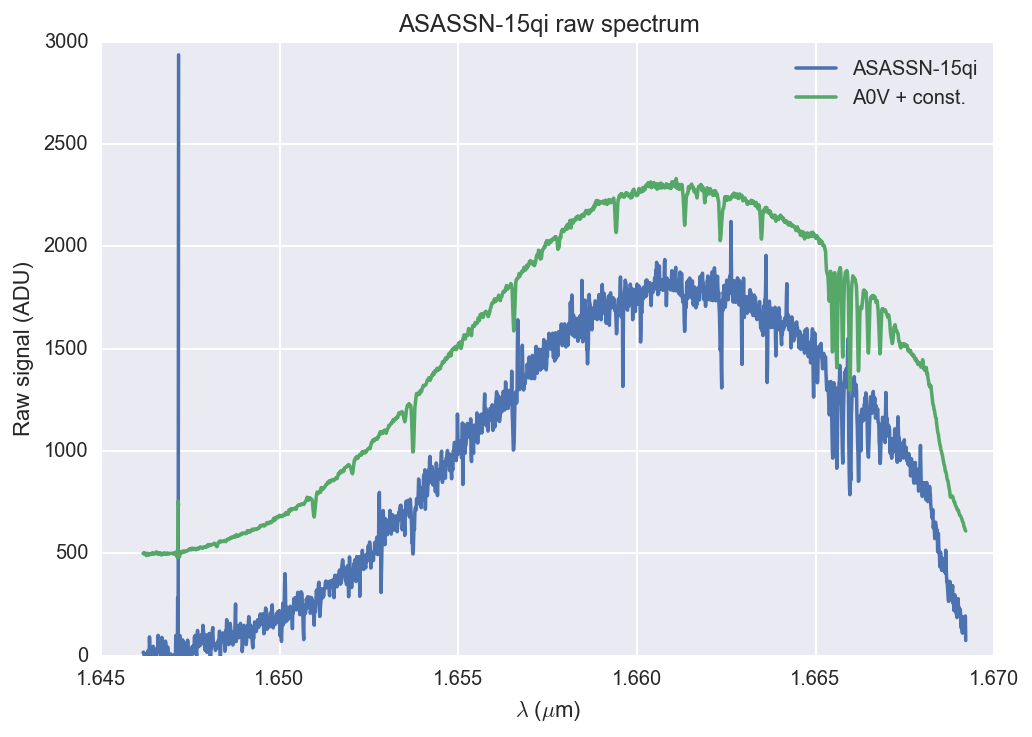

In [4]:
o=10
plt.plot(hdu_tar[1].data[o, :], hdu_tar[0].data[o, :], label='{OBJECT}'.format(OBJECT=hdr['OBJECT']))
plt.plot(hdu_raw[1].data[o, :], hdu_raw[0].data[o, :]/7.5 +500, label='A0V + const.')
plt.legend(loc='best')
plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.title('{OBJECT} raw spectrum'.format(OBJECT=hdr['OBJECT']));

**Figure 1**: The spectral response of IGRINS includes both instrumental and telluric effects.

## Estimating the spectral response

The net spectral response is composed of many terms.  The main features can be broken up into the immersion grating blaze function, $t_{IG}$, which depends on wavelength and spectral order $m$.  The telluric transmission, $t_{\oplus}$, is mostly in fine-grained lines.

$$f_{raw} = f_{\star} \cdot t_{net} \\
t_{net} = t_{inst} \cdot t_{\oplus} \\
t_{inst} = t_{IG}(m) \cdot t_{VPH} \cdot t_{dichroic} \cdot t_{HJST} \cdot t_{optics} $$

Where:  
$t_{net}$ is the **net spectral response** including all known calibration effects.  
$t_{inst}$ is the component of the spectral response attributable to the **instrument and telescope**.  
$t_{\oplus}$ is the component of the spectral response attributable to **Earth's atmospheric absorption** (i.e. *telluric* absorption).  
$t_{IG}$ is the component of the spectral response attributable to the **silicon immersion grating**.  
$t_{VPH}$ is the component of the spectral response attributable to the **volume phase holographic grating**.  
$t_{dichroic}$ is the component of the spectral response attributable to the **dichroic**.  
$t_{HJST}$ is the component of the spectral response attributable to the **Harlan J. Smith Telescope**.  
$t_{optics}$ is a catch-all for everything else in IGRINS, including camera, mirrors, detector, etc.  
and  
$f_{raw}$ is the **observed raw flux**, measured in analog-to-digital units (ADUs).  
$f_{\star}$ is the **absolute stellar flux** above the Earth's atmosphere.

### Ideal scenario, or *The Right Thing to Do &trade;*

#### 1. Determine the instrumental response and chatacterize how it varies in time.
We would use high precision lab data of each component to estimate each component's contribution, and multiply them together to get a lab-based predicted $\hat t_{inst, lab}$.  We would then compare $\hat t_{net, lab}$ to on-sky measurements $\hat t_{inst, sky}$, and then refine and adopt a fixed $\hat t_{inst}$.  Lastly, we would monitor whether $\hat t_{inst}$ changes based on temperature, time, observing run, etc., and then refine our model for $\hat t_{inst}(t)$.

#### 2. Determine the telluric response and characterize how it varies with atmospheric properties.
We would make many observations of the sky in different atmospheric conditions and airmasses.  We would fit atmospheric models to these spectra to see how well the models perform.  We could build semi-empirical models, and use near-contemporaneous observations of relatively-featureless A0V spectra to determine a $\hat t_{\oplus}$ for the moment of the target star observations.

### Pragmatic scenario, or *What We Actually Do &trade;*

We estimate a spectral shape from a single, near-contemporaneous, A0V star spectrum and apply it to the target star spectrum.  The noise $\epsilon$ from the standard star observation is included in the estimated response function.

$$\hat t_{inst} = \mathcal{F}_{LPF} \left[ \frac{f_{std, raw}+ \epsilon}{f_{std \star}} \right]$$

$$\hat t_{\oplus} = \frac{f_{std, raw}+ \epsilon}{\hat t_{inst}}$$

Where:  
$f_{std, raw}$ is the observed A0V star spectrum.  
$f_{std \star}$ is a nearly-perfect **model of the standard star** (*e.g* Vega).  
$\mathcal{F}_{LPF}$ is a **low-pass-filter** algorithm, that pools information from specral flat fields.   
and  
$\hat t_{inst}$ is the estimator for the instrumental response function.  
$\hat t_{\oplus}$ is the estimator for the telluric response function.  

The IGRINS pipeline package provides $\hat t_{net}$ broken into a low-pass and high-pass components to approximate $\hat t_{inst}$ and $\hat t_{\oplus}$, respectively.

### Let's look at the two components:

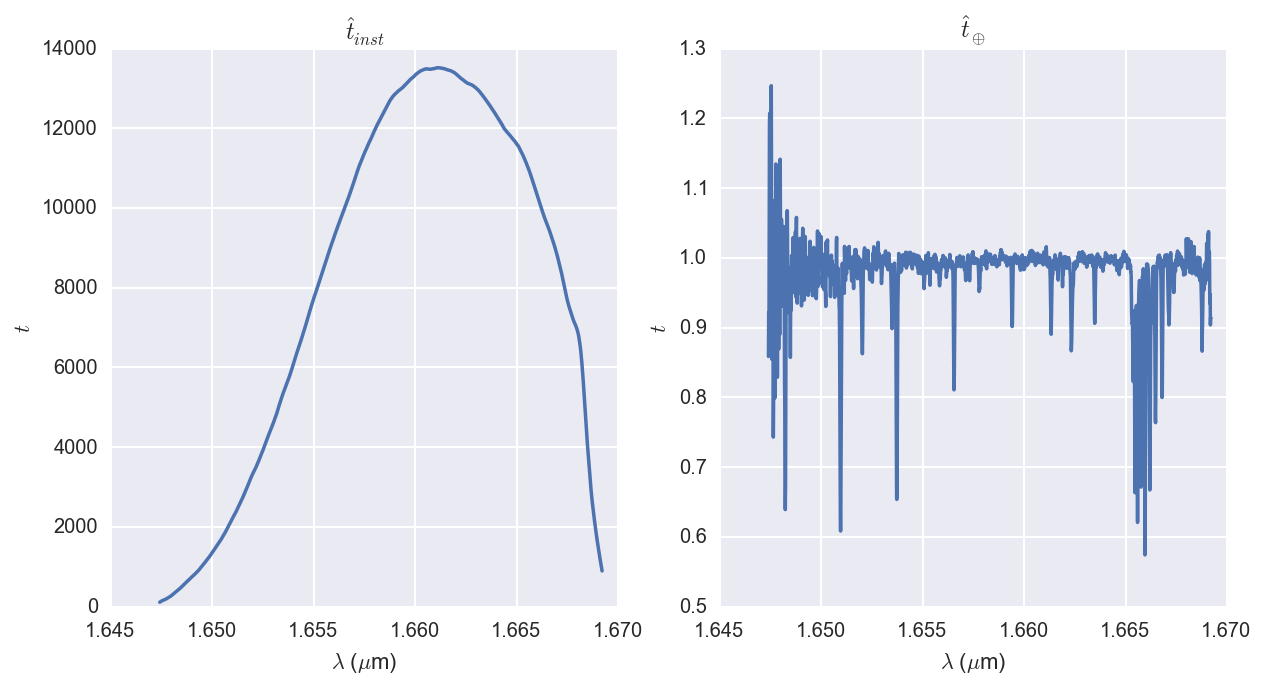

In [5]:
fig = plt.figure(figsize=(10, 5))

#Plot 1: $t_{inst}$
ax = fig.add_subplot(121)
t_inst = hdu_raw[0].data[o, :] / hdu_f[0].data[o, :] 
ax.plot(hdu_raw[1].data[o, :], t_inst)
ax.set_xlabel('$\lambda$ ($\mu$m)'); ax.set_ylabel('$t$'); ax.set_title('$\hat t_{inst}$')

#Plot 2: $t_{\oplus}$
ax = fig.add_subplot(122)
t_oplus = hdu_f[0].data[o, :] 
ax.plot(hdu_raw[1].data[o, :], t_oplus)
ax.set_xlabel('$\lambda$ ($\mu$m)'); ax.set_ylabel('$t$'); ax.set_title('$\hat t_{\oplus}$');

**Figure 2:** *Left-* $\hat t_{inst}$ is probably a **biased** estimator, as Jae-Joon Lee described at the IGRINS workshop.  
*Right-* It is clear that $\hat t_{\oplus}$ is a *noisy* estimator, i.e. it has high **variance**.

## Can we include the variance data to reduce the noise at the edges of orders?

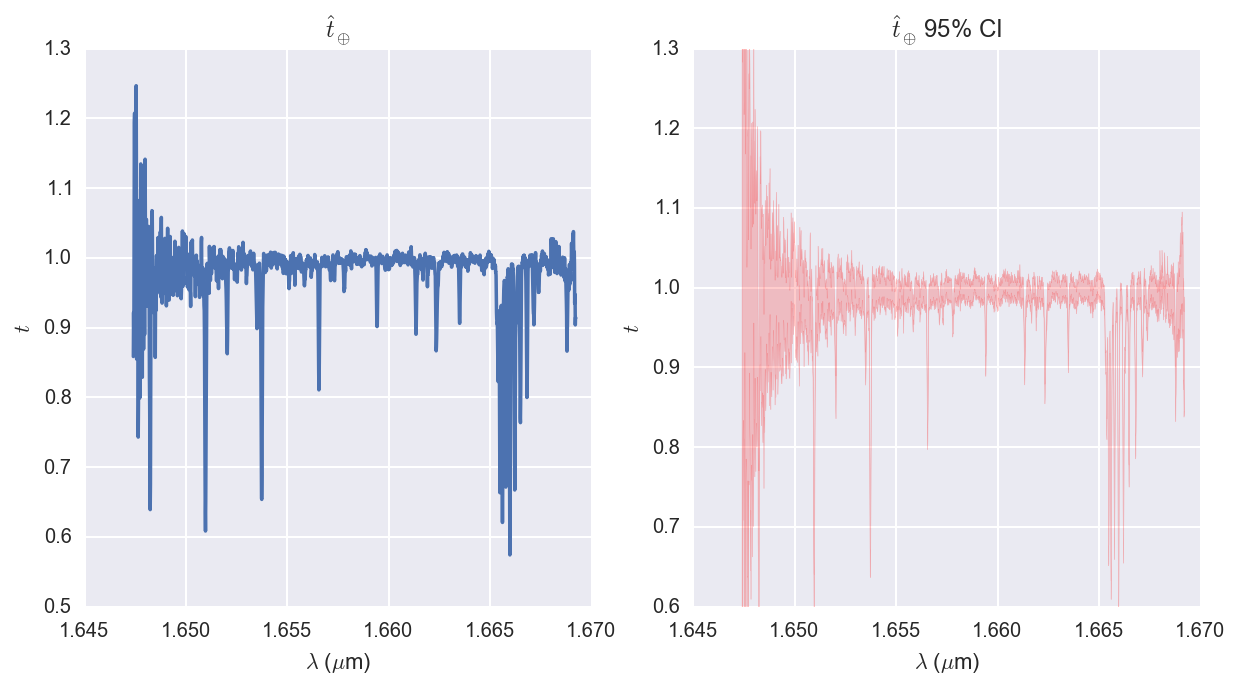

In [6]:
fig = plt.figure(figsize=(10, 5))

#Plot 1: $t_{inst}$
ax = fig.add_subplot(121)
t_oplus = hdu_f[0].data[o, :] 
ax.plot(hdu_raw[1].data[o, :], t_oplus)
ax.set_xlabel('$\lambda$ ($\mu$m)'); ax.set_ylabel('$t$'); ax.set_title('$\hat t_{\oplus}$');

#Plot 2: $t_{\oplus}$
ax = fig.add_subplot(122)
t_oplus = hdu_f[0].data[o, :]
sig = np.sqrt(hdu_var[0].data[o, :]) / t_inst
#ax.plot(hdu_raw[1].data[o, :], t_oplus)
ax.fill_between(hdu_raw[1].data[o, :], t_oplus - 1.96 * sig, t_oplus + 1.96 * sig,
                alpha=0.2, color='r', label='95% confidence interval')
ax.set_ylim(0.6, 1.3)
ax.set_xlabel('$\lambda$ ($\mu$m)'); ax.set_ylabel('$t$'); ax.set_title('$\hat t_{\oplus}$ 95% CI');

## Let's clean the data.

Plot the flattened target spectrum: 
### $\frac{f_{raw}}{\hat t_{inst}}$

In [7]:
dx0, dx1 = 1500, 1900 #Pick the middle 1000 pixels
sub_sample_y = hdu_f[0].data[o, dx0:dx1]
sub_sample_x = hdu_raw[1].data[o, dx0:dx1]

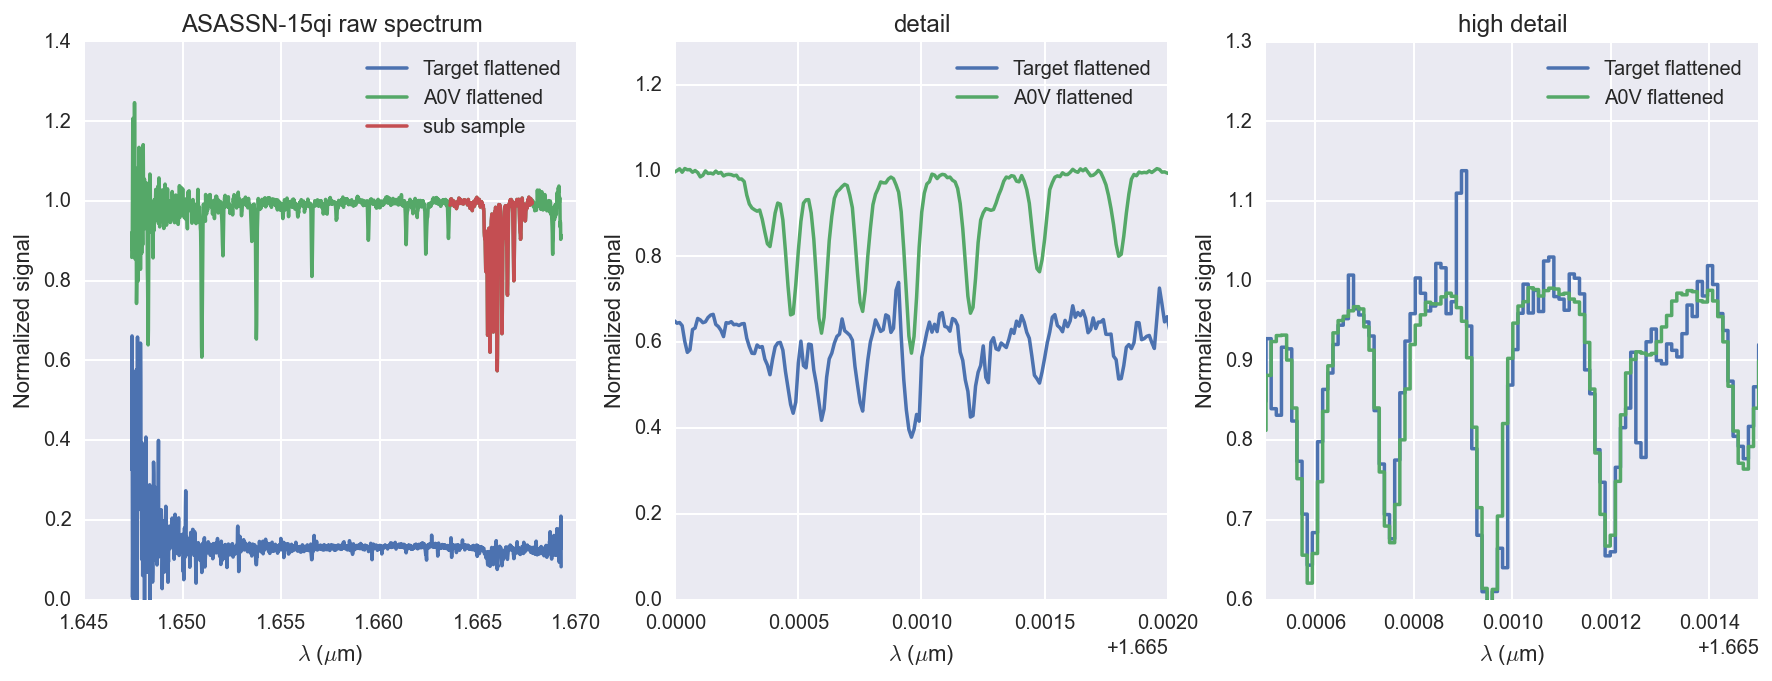

In [8]:
o=10
plt.figure(figsize=(15, 5))

plt.subplot(131)
tar_f = hdu_tar[0].data[o, :] / t_inst
plt.plot(hdu_tar[1].data[o, :], tar_f, label='Target flattened')
plt.plot(hdu_raw[1].data[o, :], hdu_f[0].data[o, :], label='A0V flattened')
plt.plot(sub_sample_x, sub_sample_y, label='sub sample')
plt.legend(loc='best')
plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('{OBJECT} raw spectrum'.format(OBJECT=hdr['OBJECT']));

plt.subplot(132)
tar_f = hdu_tar[0].data[o, :] / t_inst
plt.plot(hdu_tar[1].data[o, :], tar_f*5.0, label='Target flattened')
plt.plot(hdu_raw[1].data[o, :], hdu_f[0].data[o, :], label='A0V flattened')
plt.legend(loc='best')
#plt.xlim(1.655, 1.660)
plt.xlim(1.665, 1.667)
plt.ylim(0,1.3)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('detail');

plt.subplot(133)
tar_f = hdu_tar[0].data[o, :] / t_inst
plt.step(hdu_tar[1].data[o, :], tar_f*7.7, label='Target flattened')
plt.step(hdu_raw[1].data[o, :], hdu_f[0].data[o, :], label='A0V flattened')
plt.legend(loc='best')
plt.xlim(1.6655, 1.6665)
plt.ylim(0.6, 1.3)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('high detail');

In [9]:
from scipy import signal

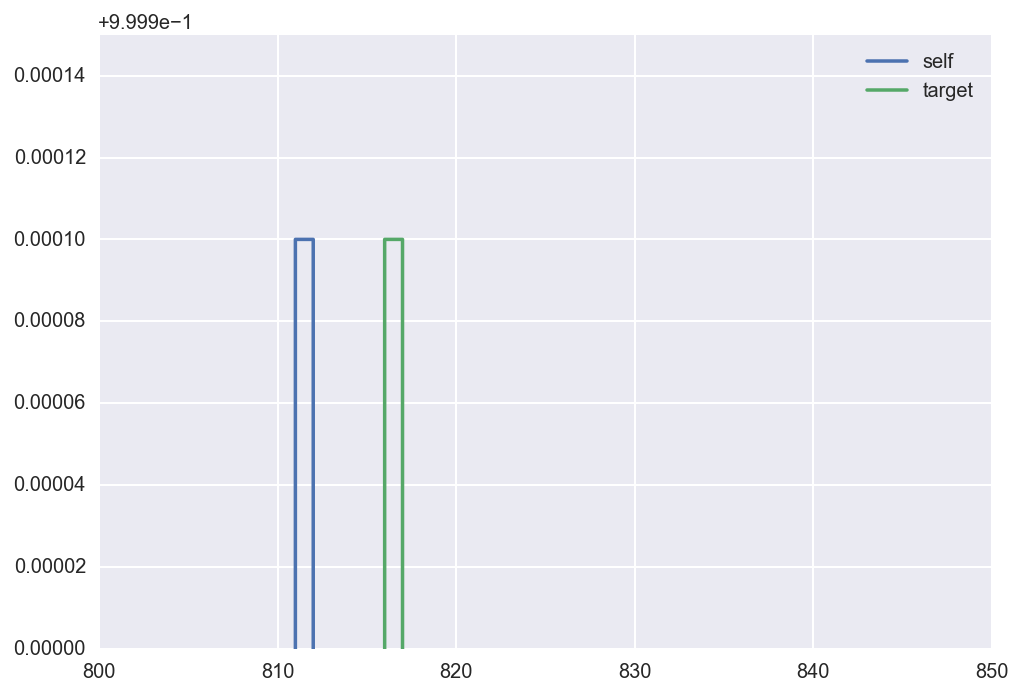

In [10]:
dx0, dx1 = 500, 1900 #Pick the middle 1000 pixels

cor1 = signal.correlate(tar_f/0.5, hdu_f[0].data[o, dx0:dx1], mode='same')
cor2 = signal.correlate(tar_f/0.5, tar_f[dx0:dx1]*7.7, mode='same')
x = np.arange(2048)
plt.step(x, cor1/np.nanmax(cor1), label='self')
plt.step(x, cor2/np.nanmax(cor2), label='target')
plt.ylim(0.9999, 1.00005)
#plt.xlim(1160, 1180)
plt.xlim(800, 850)
plt.legend(loc='best')

### The end for now.